<a href="https://colab.research.google.com/github/Rafaloga/ECG-Paper-Record-to-Digital-Signal-Conversion-Challenge/blob/main/code/ECG_Paper_Record_to_Digital_Signal_Conversion_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Challenge: ECG Paper Record to Digital Signal Conversion**

This challenge involves developing an image processing algorithm using \textit{OpenCV} or similar libraries to convert ECG paper records into digital signals. The process includes image preprocessing to enhance quality, extracting ECG traces from various layouts, and digitizing these traces. The provided dataset contains diverse ECG paper record images. The solution encompasses reading, preprocessing, segmentation, and digitization, enabling the conversion of paper records into digital ECG data.

*Google Colab (Colaboratory)* was used to implement the application, as it presents a great option for coding due to its free access to cloud computing resources, no local setup required, real-time collaboration, integration with Google Drive, pre-installed libraries, and easy saving/exporting of results.

**Initialization: Libraries used**

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## **Stage 1: Image Preprocessing**
The primary objective of the Image Preprocessing stage is to prepare paper-based electrocardiogram (ECG) record images for further digital processing. This phase involves multiple steps aimed at improving image quality, aligning orientation, and ensuring consistency across all images:

### **Image reading and greyscale conversion**

In [ ]:
# Read the image
# If you are suing colab, drop your file on the "Files" secion on the left of the platform
img = cv2.imread('/content/Normal(1).jpg')
#img = cv2.imread('/content/MI(1).jpg')
#img = cv2.imread('/content/HB(1).jpg')
#img = cv2.imread('/content/PMI(1).jpg')

# Get the grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### **Orientation Correction**
To standardize and align all ECG images, orientation correction is applied:

In [ ]:
# Determines the orientation of the image based on the vertical histogram
def determine_orientation(image):
    # Calculate a vertical histogram by summing pixel values along columns
    hist = np.sum(image, axis=1)

    # Compare the sum of the first half of the histogram to the second half
    top_half = np.sum(hist[:len(hist)//2])
    bottom_half = np.sum(hist[len(hist)//2:])

    # If the top half has more "weight" than the bottom half, it's upside down
    if top_half > bottom_half:
        return cv2.rotate(image, cv2.ROTATE_180)
    else:
        return image

# Function to rotate the image without losing any content
def rotate_image(image, angle):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the bounding rectangle of the non-zero pixels in the image
    rect = cv2.boundingRect(cv2.findNonZero(image))

    # Extract the width and height of this bounding rectangle
    width_rotated = rect[2]
    height_rotated = rect[3]

    # Calculate the center of the new and original image
    center_rotated = (width_rotated // 2, height_rotated // 2)
    center_original = (width // 2, height // 2)

    # Get the rotation matrix for the given angle
    matrix = cv2.getRotationMatrix2D(center_original, angle, 1)

    # Decompose the matrix into cosine and sine values
    cos_val = np.abs(matrix[0, 0])
    sin_val = np.abs(matrix[0, 1])

    # Calculate new dimensions after rotation
    new_width = int((height * sin_val) + (width * cos_val))
    new_height = int((height * cos_val) + (width * sin_val))

    # Adjust the translation part of the rotation matrix
    matrix[0, 2] += (new_width / 2) - center_original[0]
    matrix[1, 2] += (new_height / 2) - center_original[1]

    # Apply the affine transformation
    rotated_image = cv2.warpAffine(image, matrix, (new_width, new_height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

# Corrects the image orientation based on detected lines
def correct_orientation(img):
    # Detect edges in the image
    edges = cv2.Canny(img, 10, 150, apertureSize=3)

    # Detect lines in the image using the Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/720, threshold=1000, minLineLength=200, maxLineGap=5)

    angle = 0
    if lines is not None:
        angles = []

        # For each detected line, compute its angle
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angles.append(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)

        # Use the median angle for rotation
        angle = np.median(angles)

    return rotate_image(img, angle)  # Use the rotate_image function


# Determine the orientation of the image based on the vertical histogram
# This step was made because using only corner and line detection was not
# sufficient in some cases, as when, for instance, the image was rotated 180º,
# the lines and corners were oriented in such a way that the corrected image
# ended up reversed.
img_corrected = determine_orientation(gray)

# Apply orientation correction by using  corner and line detection algorithms
img_rotated = correct_orientation(img_corrected)


### **Image Enhancementand Preparation**
Once the image is correctly oriented, the following steps are performed to prepare the image for the future digitization.

In [ ]:
# Smooth the image using a Gaussian filter
blurred_image = cv2.GaussianBlur(img_rotated, (5, 5), 0.7)

# Use Otsu's thresholding to distinguish foreground and background
_, binary_global = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

### **Images visualization**
Different transformed images are shown to see the results.

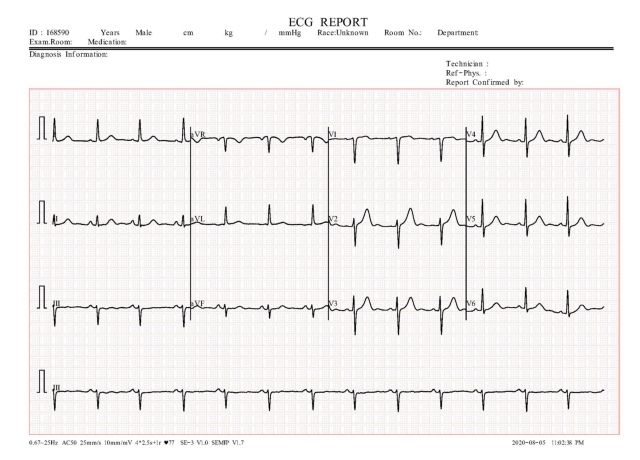

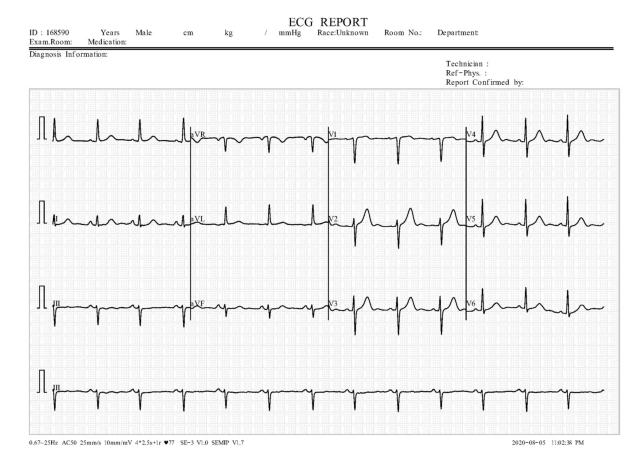

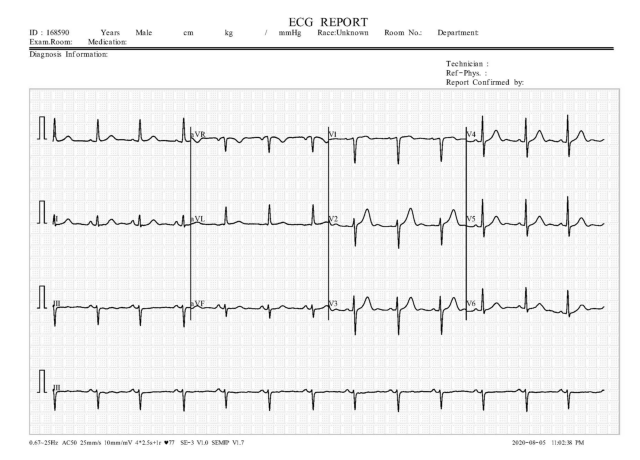

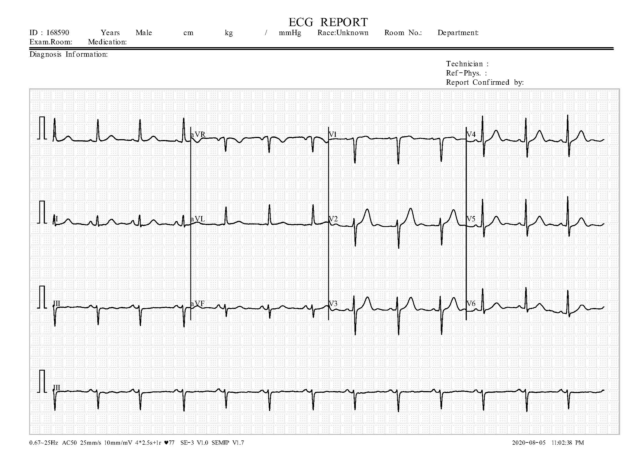

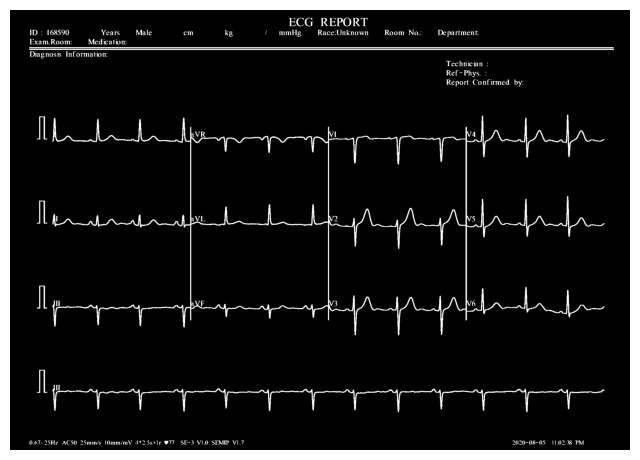

In [ ]:
# Show each image in a separate figure using plt

# Original image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Grayscale image
plt.figure(figsize=(8, 8))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

# Corrected image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Smoothed image
plt.figure(figsize=(8, 8))
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.show()

# Otsu's Threshold
plt.figure(figsize=(8, 8))
plt.imshow(binary_global, cmap='gray')
plt.axis('off')
plt.show()

## **Stage 2: ECG Trace Extraction**
In the second stage, the focus was on the extraction of electrocardiogram (ECG) traces from ECG paper records represented as images. This stage involved several image processing steps aimed at isolating and segmenting the individual ECG traces within the image.


### **Contour Detection and Sorting**
The first step involved detecting contours in the binary image of the ECG paper record. Contours are regions of interest that can potentially contain the ECG traces. Contours were sorted in descending order of their areas to ensure that the largest contours corresponded to the ECG traces, which are typically the most prominent features in the image. The two largest contours correspond to the area where thw 12 traces are together and to the area where the 13th trace is placed.

In [ ]:
# Find contours in the binary image (binary_global), where the 2 largest contours
# correspond to the area where thw 12 traces are together and to the area where the 13th trace is placed.

contours, _ = cv2.findContours(binary_global, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours in descending order of their area
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

### **Filtering and Cropping**
To extract the ECG traces, the detected contours were filtered based on a threshold area. For each selected contour, a series of operations was applied to adjust and crop the region of interest around the contour. This process involved increasing the size of the bounding rectangle around the contour by a certain percentage and ensuring that the resulting coordinates were non-negative. This was made beacause without this enlargement, in the next step when the traces are differentiated, some of them would have truncated areas, and therefore, the optimal result would not be achieved.

In [ ]:
# Create a list to store the cropped regions of the original image
cropped_original = []

# List to store the coordinates of the cropped regions
crops_coordinates = []

# Filter contours, crop them, and save them in the list
for contour in contours:
    # Filter contours based on a minimum area threshold
    # (1000 pixels in this case for obtaining the 2 areas mentioned before)
    if cv2.contourArea(contour) > 1000:
        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Increase the size of the bounding rectangle by 20% in each dimension
        # beacause without this enlargement, in the next step when the traces
        # are differentiated, some of them would have truncated areas,
        # and therefore, the optimal result would not be achieved.
        increase_percent = 0.20  # 20% increase
        x -= int(w * increase_percent / 2)
        y -= int(h * increase_percent / 2)
        w = int(w * (1 + increase_percent))
        h = int(h * (1 + increase_percent))

        # Ensure that the coordinates are not negative
        x = max(0, x)
        y = max(0, y)

        # Crop the region of interest from the binary image
        cropped_img = binary_global[y:y+h, x:x+w]

        # Append the cropped region and its coordinates to their respective lists
        cropped_original.append(cropped_img)
        crops_coordinates.append((x, y, w, h))

### **Crops visualization**

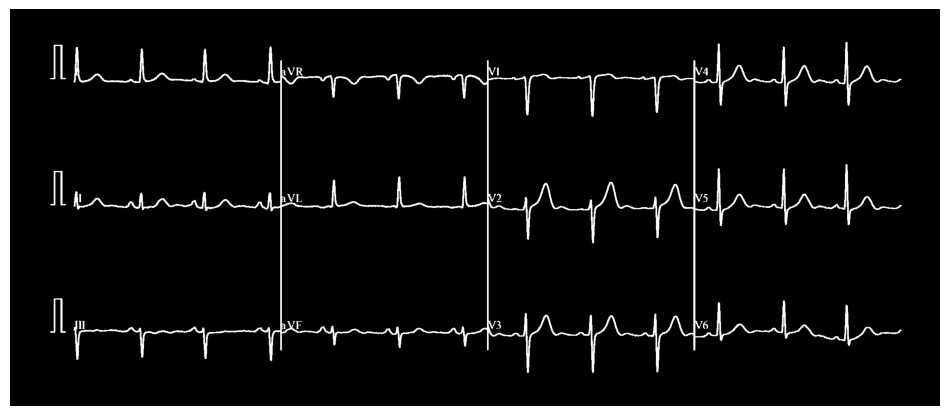

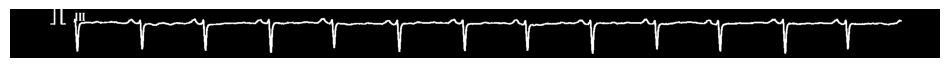

In [ ]:
# Display the first two cropped regions
plt.figure(figsize=(12, 12))
plt.imshow(cropped_original[0], cmap='gray')
plt.axis('off')
plt.figure(figsize=(12, 12))
plt.imshow(cropped_original[1], cmap='gray')
plt.axis('off')
plt.show()

### **Vertical Edge Detection**
In order to be able to diferenciate between the 12 connected traces, the Sobel operator was applied to detect vertical edges, as the traces are separated by a vertical line. The Sobel operator enhances areas of rapid intensity change in the image, which often correspond to edges. This step was only performed on the biggest area, where the 12 traces reamin together as the 13th contour is already separated from the rest.

In [ ]:
# Vertical edge detection using Sobel operator as the traces are separated by a vertical line.
sobelx = cv2.Sobel(cropped_original[0], cv2.CV_64F, 1, 0, ksize=3)

# Create a copy of the cropped image with the 12 traces
crop = cropped_original[0].copy()

### **Dilation and Line Detection**
A dilation operation was performed on the Sobel-transformed image to improve the detection of vertical lines. Subsequently, the Hough Line Transform was used to detect lines in the dilated image. These lines represent the divisions between individual ECG traces. Once the lines that separate the traces are detected, these lines are removed so that the traces are not connected to each other. Once the traces are no longer connected, you can apply a contour-finding algorithm, which will return the separated traces as the contours found.

In [ ]:
# Dilate the edges to enhance and connect them
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(sobelx, kernel, iterations=1)

# Detect lines using the Hough Line Transform
lines = cv2.HoughLinesP(crop.astype(np.uint8), 1, np.pi/1000, 10, minLineLength=300, maxLineGap=1)

# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(crop, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Segment the image based on detected lines
for i in range(len(lines) - 1):
    lead = crop[:, lines[i][0][0]:lines[i+1][0][0]]



### **Filtered Crop visualization**

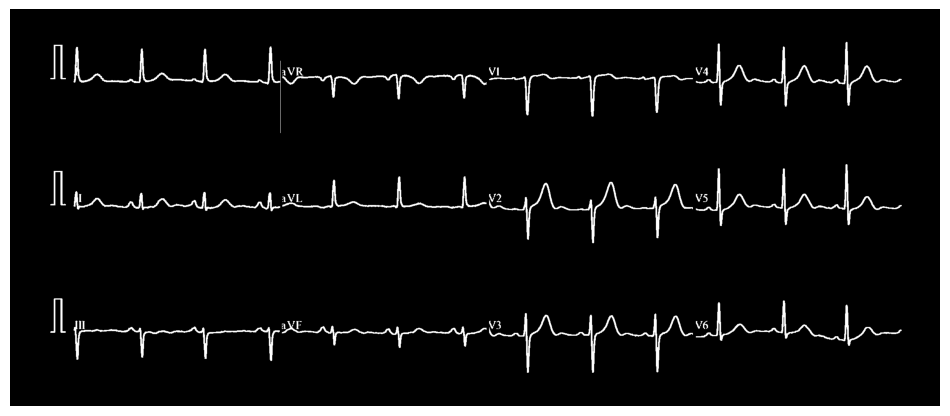

In [ ]:
# Display the final image with detected lines
# The 12 traces now are not connected, so the different contours from each trace can be extracted
plt.figure(figsize=(12, 12))
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

### **Segmentation of 12 ECG Traces**
To segment the 12 traces, the first step is to find the contours of the previously vertical-lines erased image. Then, bounding boxes for these contours are calculated , including their (x, y) coordinates, width, and height. These bounding boxes are filtered based on their area, retaining only those with an area greater than a threshold (to just obtain the traces signals). For each set of sorted coordinates, a crop is obtained with the corresponding region of each of the trace signals (the height of the cropped regions are adjusted by increasing it by 20\% to ensure that the entire signal is captured).

In [ ]:
# Find contours that correspond to the traces
contours, _ = cv2.findContours(crop, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get bounding boxes and their coordinates (x, y, width, height) and filter by area
bounding_boxes = [(cv2.boundingRect(contour), contour) for contour in contours if cv2.contourArea(contour) > 2000]

# Get the (x, y, width, height) coordinates of the bounding boxes
coordinates = [(box[0], box[1], box[2], box[3]) for box, _ in bounding_boxes]

# Sort the coordinates, as they were placed un a 3x4 layout
# Sort the coordinates by the y-coordinate
coordinates.sort(key=lambda coord: coord[1])

# Divide the coordinates into three parts
num_parts = 3
part_size = len(coordinates) // num_parts

parts = [coordinates[i:i+part_size] for i in range(0, len(coordinates), part_size)]

# Sort each part by the x-coordinate
for i, part in enumerate(parts):
    parts[i] = sorted(part, key=lambda coord: coord[0])

sorted_coordinates = [coord for part in parts for coord in part]

# Create a list to store cropped images
cropped_images = []
cropped_coordinates = []  # Create a list to store coordinates

# Filter contours and crop following the order, and adjust size by 20% in height only.
# The height adjustment is made to ensure the whole signal is captured in the rectangle
for index, (x, y, w, h) in enumerate(sorted_coordinates):
    # Calculate a 20% increase in height
    increase_percent = 0.20  # 20% increase
    h_increase = int(h * increase_percent / 2)

    # Adjust coordinates to increase size by 20% in height only
    y -= h_increase
    h += h_increase * 2

    # Make sure coordinates are not negative
    y = max(0, y)

    # Crop the image using the adjusted coordinates
    final = crop[y:y+h, x:x+w]
    cropped_images.append(final)  # Add the cropped image to the list

    # Store the coordinates in the cropped_coordinates list
    cropped_coordinates.append((x, y, w, h))

# Add the 13th trace to the list
cropped_images.append(cropped_original[1])
cropped_coordinates.append(crops_coordinates[1])



### **Traces Visualization**

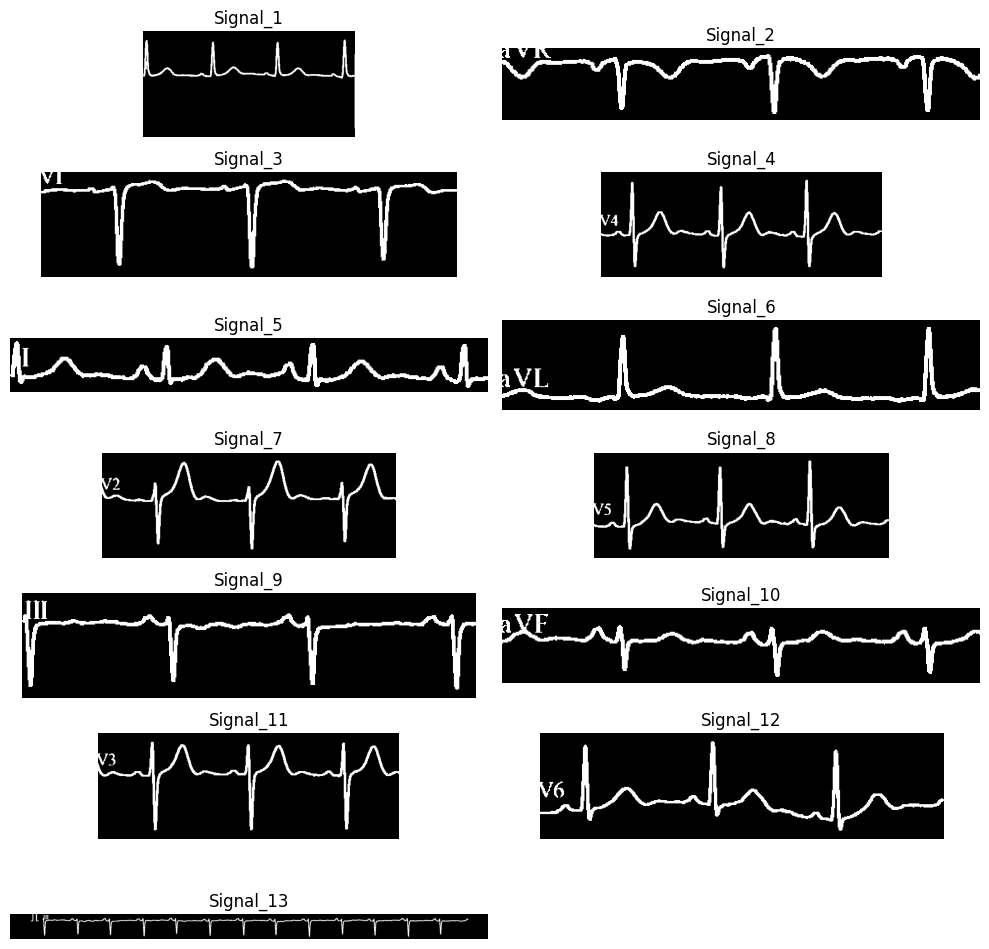

In [ ]:
# Calculate the number of rows and columns for subplots
num_images = len(cropped_images) + 1  # Add 1 for the 14th image
num_columns = 2  # 2 columns
num_rows = (num_images + num_columns - 1) // num_columns

# Create a single figure to display images in 2 columns
plt.figure(figsize=(10, 10))  # Define the figure size

for index, image in enumerate(cropped_images):
    plt.subplot(num_rows, num_columns, index+1)  # Create a subplot
    plt.imshow(image, cmap='gray')  # Assuming it's a grayscale image
    plt.title(f"Signal_{index+1}")
    plt.axis('off')



plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

## **Stage 3: Digitization**
The third stage of this project focuses on transforming the paper-based electrocardiogram (ECG) signals into a digital format, making them accessible for advanced analysis and integration into healthcare systems. This stage involves the following key steps:

### **Signal extraction**
After successfully extracting and separating individual ECG traces from the paper records in the previous stage, the next step is to prepare these traces for digitization. These traces are representedn then as contours, and the goal is to convert them into a digital format.
To identify contours, an initial step is to apply thresholding to the image. Thresholding is a technique that separates objects or features of interest from the background. It sets a certain pixel value as a threshold and classifies all pixels above that threshold as one type and all pixels below it as another. This helps isolate the lines or shapes of interest from the rest of the image. This step was made before, when the binarization of the image was performed. After thresholding, a contour detection algorithm is applied to the image. Contours are essentially the outlines of objects or shapes within the image. The algorithm identifies areas of the image where pixel intensity changes, signifying the presence of an object boundary or shape.
Among the detected contours, the algorithm selects the largest one. This is often done because the largest contour is likely to represent the primary object or feature of interest in the image. The size of a contour is determined by the number of points that define it. This is the case, since the trace images biggest contour is the signal itself.

The selected largest contour may undergo further processing, such as resizing or smoothing, depending on the final application to ensure that it meets specific requirements or standards. This processing can enhance the quality and usability of the contour data.

In [ ]:
original_contours = []
largest_contours = []
absolute_contours = []  # List to store contours in terms of the entire image


# Loop through all crops in cropped_images
for index, image in enumerate(cropped_images):
    if index >= len(cropped_coordinates):
        continue
    # Find contours in the current image
    contours = measure.find_contours(image, 0.1)

    # Find the largest contour shape
    contours_shapes = sorted([x.shape for x in contours])[::-1][0:1]

    # Store the largest contour in this variable
    largest_contour = None

    # Store the original contour
    original_contour = None

    # Find the largest contour in this image
    for contour in contours:
        if contour.shape in contours_shapes:
            # Resize the contour to an arbitrary value (it can vary depending on the requirements of the application)
            # This is made to ensure all the signals have the same size, so they can be stored and compared easily.
            resized_contour = resize(contour, (1023, 2))
            # Store the largest contour
            largest_contour = resized_contour
            original_contour = contour

    # Add the largest and original contour to the lists
    largest_contours.append(largest_contour)
    original_contours.append(original_contour)

    # Now, adjust the original_contour's coordinates to be relative to the original image
    # This way all the signals can be plotted again together
    x_offset, y_offset, _, _ = cropped_coordinates[index]
    absolute_contour = np.array([[y + y_offset, x + x_offset] for y, x in original_contour])
    absolute_contours.append(absolute_contour)



### **Traces and contours visualization**

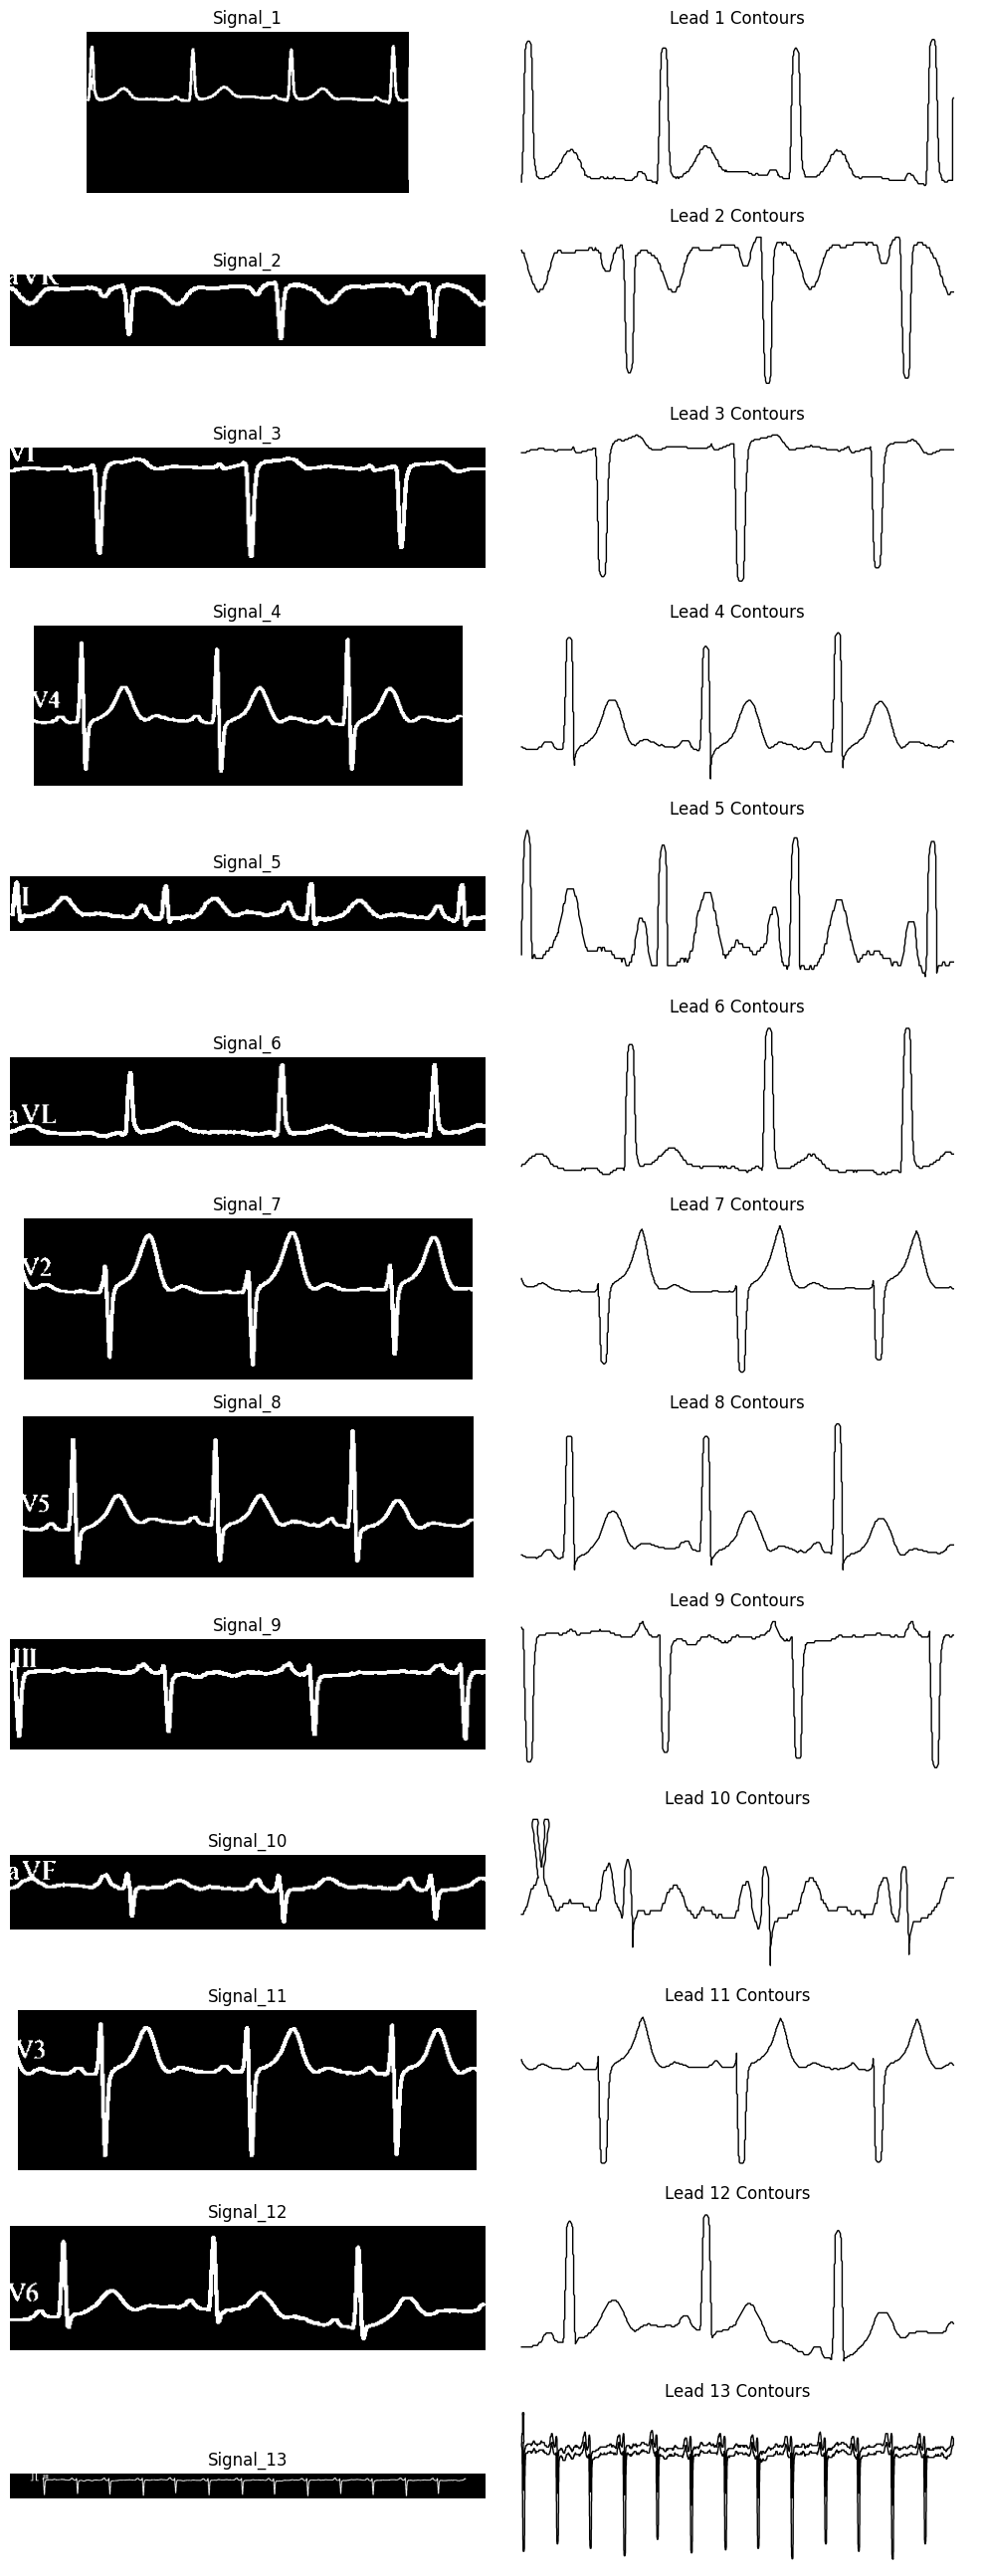

In [ ]:
# Define the height of each subplot
subplot_height = 2.0  # Adjust this value to control vertical spacing

# Calculate the total height of the figure
fig_height = len(cropped_images) * subplot_height

# Create subplots for plotting with individual heights
fig, axes = plt.subplots(len(cropped_images), 2, figsize=(10, fig_height))

for index, (image, ax) in enumerate(zip(cropped_images, axes)):
    ax_signal, ax_contours = ax

    # Show the signal image on the left subplot
    ax_signal.imshow(image, cmap='gray')
    ax_signal.set_title(f"Signal_{index + 1}")
    ax_signal.axis('off')

    # Plot the largest contour found on the right subplot
    ax_contours.plot(absolute_contours[index][:, 1], absolute_contours[index][:, 0], linewidth=1, color='black')
    ax_contours.set_title(f"Lead {index + 1} Contours")
    ax_contours.axis('off')
    ax_contours.invert_yaxis()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## **Signal Smoothing**
To ensure the accuracy and consistency of the digitized signals, a smoothing process is applied. This process involves reducing noise and enhancing the clarity of the ECG traces. It improves the visual interpretation of the signals and prepares them for further analysis. Depending on the final application, the smoothing applied will differ or won´t be used.

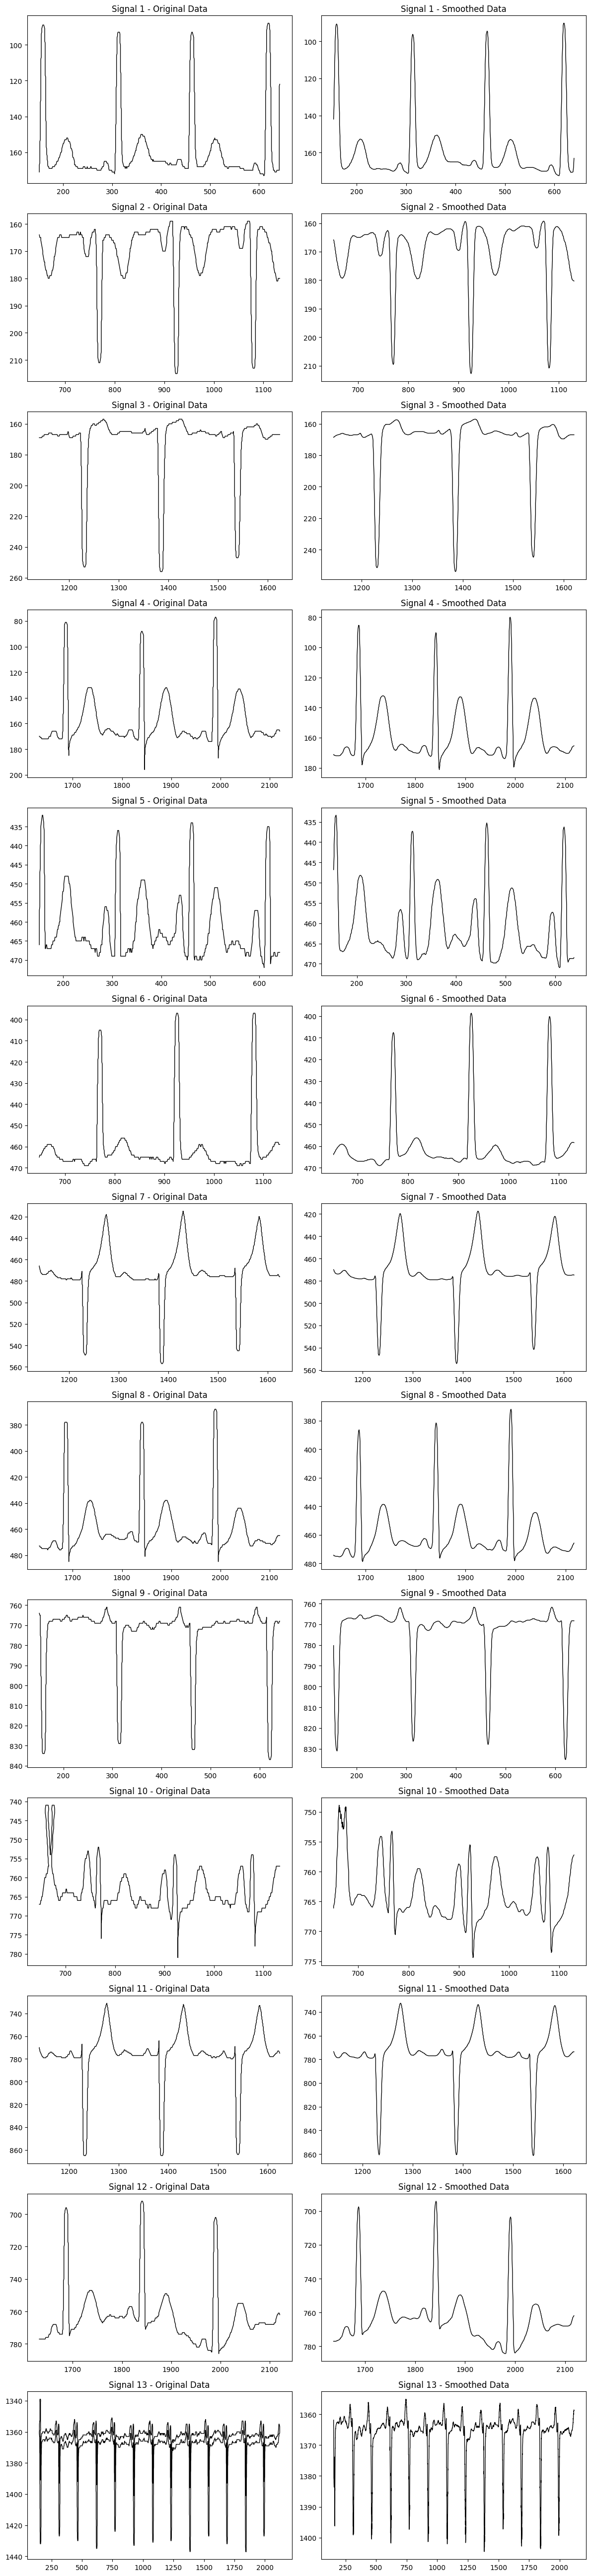

In [ ]:
# Number of signals
num_signals = len(largest_contours)

# Moving average window size to smooth the signal. It can vary depending on the final app
window_size = 10

# Lists to store the original data and smoothed data for each signal
original_data_list = []
smoothed_data_list = []

# Create a figure with subplots for all signals (original and smoothed)
fig, axs = plt.subplots(num_signals, 2, figsize=(12, 4 * num_signals))

# Loop through the signals
for i in range(num_signals):
    # Get the original data for the current signal
    original_data = absolute_contours[i]

    # Configure the first subplot (left) to display the original data
    axs[i, 0].plot(original_data[:, 1], original_data[:, 0], linewidth=1, color='black')
    axs[i, 0].set_title(f'Signal {i + 1} - Original Data')
    axs[i, 0].invert_yaxis()  # Invert the Y-axis if needed

    # Apply moving average smoothing to the current signal
    df = pd.DataFrame(original_data, columns=['Y', 'X'])
    central_line = df.groupby('X')['Y'].mean().reset_index()
    central_line['Y_smooth'] = central_line['Y'].rolling(window=window_size, center=True).mean()

    # Add the smoothed DataFrame to the list
    smoothed_data_list.append(central_line)

    # Add the original data to the list
    original_data_list.append(original_data)

    # Configure the second subplot (right) to display the smoothed data
    axs[i, 1].plot(central_line['X'], central_line['Y_smooth'], linewidth=1, color='black', linestyle='solid')
    axs[i, 1].set_title(f'Signal {i + 1} - Smoothed Data')
    axs[i, 1].invert_yaxis()  # Invert the Y-axis if needed

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()




### **Signal Normalization**
After smoothing, the ECG signals are normalized to ensure that they fall within a consistent numerical range. Normalization is essential for standardizing the signals, making them comparable, and facilitating meaningful analysis. It ensures that all signals have a similar scale and range of values.

In [ ]:
# Create DataFrames from the original data and add a 'Signal' column so they can be found in the csv file
original_data_list_df = [pd.DataFrame(data, columns=['Y', 'X']) for data in original_data_list]
for i, df in enumerate(original_data_list_df):
    df['Signal'] = i + 1  # Assign a unique signal value to each data set

# Create DataFrames from the smoothed data and add a 'Signal' column so they can be found in the csv file
smoothed_data_list_df = [pd.DataFrame(data, columns=['X', 'Y_smooth', 'Y']) for data in smoothed_data_list]
for i, df in enumerate(smoothed_data_list_df):
    df['Signal'] = i + 1  # Assign a unique signal value to each smoothed data set

# Concatenate all the original data DataFrames into one
original_data = pd.concat(original_data_list_df, ignore_index=True)

# Concatenate all the smoothed data DataFrames into one
smoothed_data = pd.concat(smoothed_data_list_df, ignore_index=True)

# Initialize the MinMaxScaler to normalize the 'X', 'X_smooth', and 'Y' columns
scaler = MinMaxScaler()

# Normalize the 'X', 'X_smooth', and 'Y' columns in the smoothed data
smoothed_data[['X', 'Y_smooth', 'Y']] = scaler.fit_transform(smoothed_data[['X', 'Y_smooth', 'Y']])


### **Data Storage**
The digitized ECG signals, both in their original and normalized forms, are stored in separate data files. These files serve as the digital representation of the ECG data. Storing the data in this format enables easy access, sharing, and integration into healthcare information systems.

In [ ]:
# Specify the CSV file name where you want to save the original data
csv_filename_original = 'original_data.csv'

# Save the original data to a CSV file without normalization
original_data.to_csv(csv_filename_original, index=False)

# Specify the CSV file name where you want to save the normalized data
csv_filename = 'normalized_data.csv'

# Save the normalized data to a CSV file
smoothed_data.to_csv(csv_filename, index=False)

print(f'Original data saved to {csv_filename_original}')
print(f'Normalized data saved to {csv_filename}')

Original data saved to original_data.csv
Normalized data saved to normalized_data.csv


### **Data Visualization**
To provide a visual comparison between the original and digitized ECG signals, visualizations are generated. These visualizations help demonstrate the effectiveness of the digitization process and provide a clear view of how the signals have been transformed from their paper-based form.

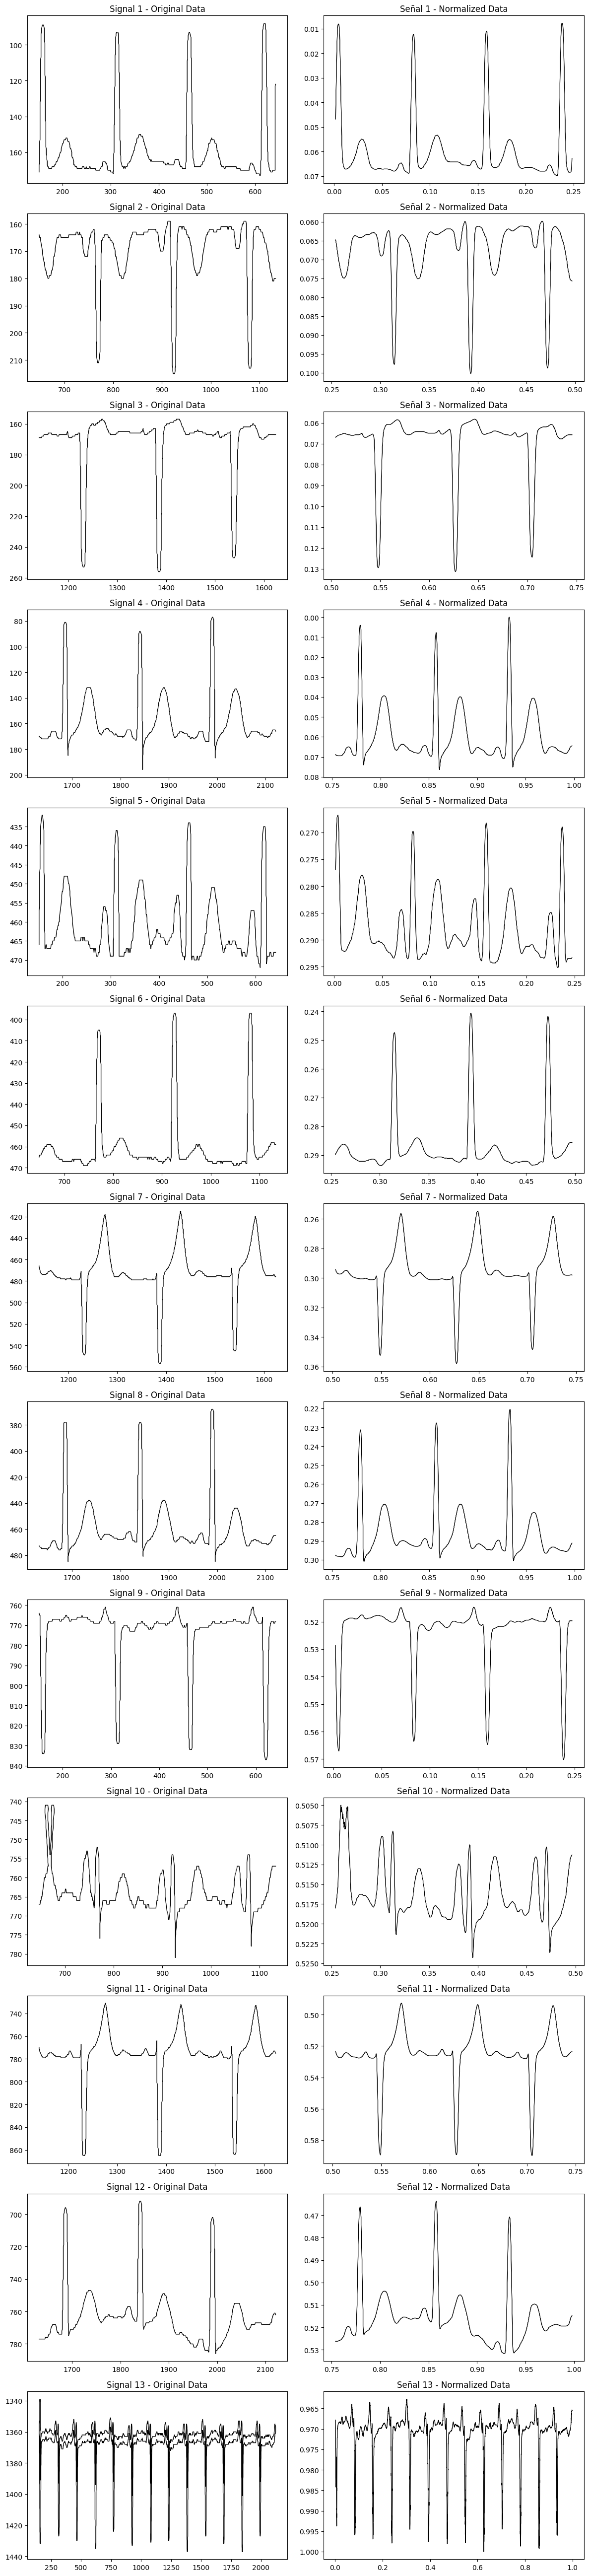

In [ ]:
# Load the original data from the CSV file
csv_filename_original = 'original_data.csv'
original_data = pd.read_csv(csv_filename_original)

# Load the normalized data from the CSV file
csv_filename = 'normalized_data.csv'
normalized_data = pd.read_csv(csv_filename)

# Number of signals (assuming each signal has a unique identification number)
num_signals = original_data['Signal'].nunique()

# Create a figure with subplots for all signals
fig, axs = plt.subplots(num_signals, 2, figsize=(12, 4 * num_signals))

# Loop through the signals
for signal_id in range(1, num_signals + 1):
    # Filter the original data for the current signal
    original_signal_data = original_data[original_data['Signal'] == signal_id]

    # Filter the normalized data for the current signal
    normalized_signal_data = normalized_data[normalized_data['Signal'] == signal_id]

    # Configure the first subplot (left) to display the original data
    axs[signal_id - 1, 0].plot(original_signal_data['X'], original_signal_data['Y'], linewidth=1, color='black')
    axs[signal_id - 1, 0].set_title(f'Signal {signal_id} - Original Data')
    axs[signal_id - 1, 0].invert_yaxis()  # Invert the Y-axis if needed


    # Configure the second subplot (right) to display the normalized data
    axs[signal_id - 1, 1].plot(normalized_signal_data['X'], normalized_signal_data['Y_smooth'], linewidth=1, color='black')
    axs[signal_id - 1, 1].set_title(f'Señal {signal_id} - Normalized Data')
    axs[signal_id - 1, 1].invert_yaxis()  # Invert the Y-axis if needed

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


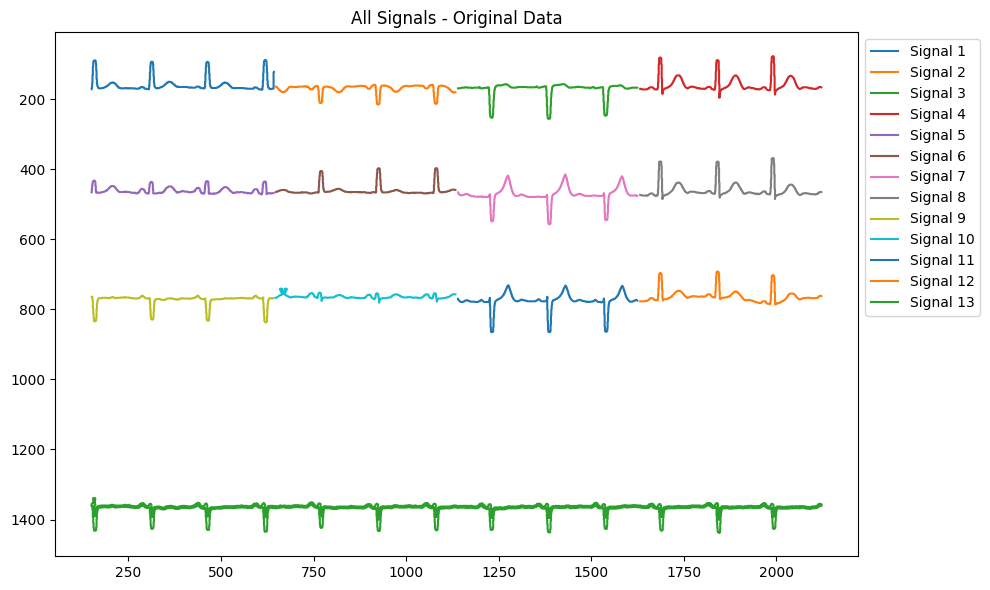

In [ ]:
# Load the original data from the CSV file
csv_filename_original = 'original_data.csv'
original_data = pd.read_csv(csv_filename_original)

# Determine the number of unique signals (assuming each signal has a unique identifier)
num_signals = original_data['Signal'].nunique()

# Create a new figure with appropriate size
plt.figure(figsize=(10, 6))

# Loop through each unique signal
for signal_id in range(1, num_signals + 1):
    # Filter the original data for the current signal
    original_signal_data = original_data[original_data['Signal'] == signal_id]

    # Plot the data of the current signal
    plt.plot(original_signal_data['X'], original_signal_data['Y'], label=f'Signal {signal_id}')

# Configure the plot
plt.title('All Signals - Original Data')
plt.gca().invert_yaxis()  # Invert the Y-axis if necessary
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add a legend to the plot
plt.tight_layout()
plt.show()


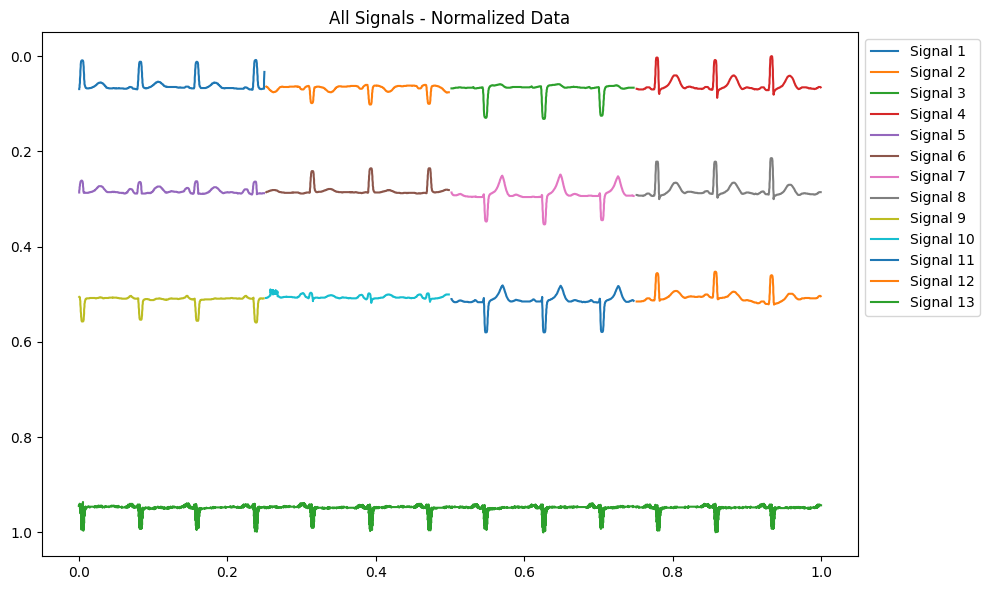

In [ ]:
# Load the normalized data from the CSV file
csv_filename_normalized = 'normalized_data.csv'
normalized_data = pd.read_csv(csv_filename_normalized)

# Determine the number of unique signals (assuming each signal has a unique identifier)
num_signals = normalized_data['Signal'].nunique()

# Create a new figure with appropriate size
plt.figure(figsize=(10, 6))

# Loop through each unique signal
for signal_id in range(1, num_signals + 1):
    # Filter the original data for the current signal
    normalized_signal_data = normalized_data[normalized_data['Signal'] == signal_id]

    # Plot the data of the current signal
    plt.plot(normalized_signal_data['X'], normalized_signal_data['Y'], label=f'Signal {signal_id}')

# Configure the plot
plt.title('All Signals - Normalized Data')
plt.gca().invert_yaxis()  # Invert the Y-axis if necessary
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add a legend to the plot
plt.tight_layout()
plt.show()


## **Conclussions**
These three phases come together to create an automated system that effectively converts paper-based ECG records into digital ECG signals, enabling their access and advanced analysis in healthcare settings.
The algorithm has shown promising results in converting paper-based ECG records into digital signals.

In conclusion, the development of an automated system for converting ECG paper records into digital signals using image processing techniques is a significant step toward improving healthcare data accessibility and analysis. While the algorithm demonstrates promise, it requires ongoing refinement and adaptation to handle a wide range of paper record scenarios. With further development and integration of advanced technologies, this system can contribute significantly to healthcare diagnosis and research.